In [1]:
!pip3 install yfinance

     |████████████████████████████████| 6.3 MB 7.8 MB/s 
  Created wheel for yfinance: filename=yfinance-0.1.64-py2.py3-none-any.whl size=24109 sha256=e0bf3fc7aa2edd98a133c1703ba1dec84f7171fa32ae9917ab4a73d3b51e800a
  Stored in directory: /root/.cache/pip/wheels/86/fe/9b/a4d3d78796b699e37065e5b6c27b75cff448ddb8b24943c288
Successfully built yfinance
  Attempting uninstall: lxml
    Found existing installation: lxml 4.2.6
    Uninstalling lxml-4.2.6:
      Successfully uninstalled lxml-4.2.6


## 1. Getting the data
Data source used is yfinance api, which extracts data from yahoo finance.

In [ ]:
import pandas as pd
import yfinance as yf
import datetime
import time
import matplotlib.pyplot as plt
from pandas.plotting import scatter_matrix
import numpy as np
from matplotlib import style
import tensorflow as tf
from tensorflow import keras

# data visualization
%matplotlib inline
style.use('ggplot')

In [ ]:
# Set the date range
start = datetime.datetime(2010,1,1)
end = datetime.datetime(2019,12,31)

In [ ]:
# get data (Apple)
df = yf.download('AAPL',start=start, end=end, progress=False)

In [ ]:
df.head()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 2515 entries, 2010-01-04 to 2019-12-30
Data columns (total 6 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   Open       2515 non-null   float64
 1   High       2515 non-null   float64
 2   Low        2515 non-null   float64
 3   Close      2515 non-null   float64
 4   Adj Close  2515 non-null   float64
 5   Volume     2515 non-null   int64  
dtypes: float64(5), int64(1)
memory usage: 137.5 KB


,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2010-01-04,7.622500,7.660714,7.585000,7.643214,6.572422,493729600
2010-01-05,7.664286,7.699643,7.616071,7.656429,6.583784,601904800
2010-01-06,7.656429,7.686786,7.526786,7.534643,6.479061,552160000
2010-01-07,7.562500,7.571429,7.466071,7.520714,6.467082,477131200
2010-01-08,7.510714,7.571429,7.466429,7.570714,6.510078,447610800


In [ ]:
df.describe()

,Open,High,Low,Close,Adj Close,Volume
count,2515.000000,2515.000000,2515.000000,2515.000000,2515.000000,2.515000e+03
mean,27.561969,27.806542,27.312041,27.568102,25.691816,2.996722e+08
std,13.996451,14.118351,13.894065,14.016253,14.207822,2.352933e+08
min,6.870357,7.000000,6.794643,6.858929,5.898012,4.544800e+07
25%,16.242322,16.345000,16.047500,16.178214,14.110814,1.247618e+08
50%,24.770000,25.055000,24.592501,24.860001,22.768208,2.220316e+08
75%,37.532501,37.956251,37.273750,37.611250,35.991234,4.068050e+08
max,72.779999,73.492500,72.029999,72.879997,72.025833,1.880998e+09


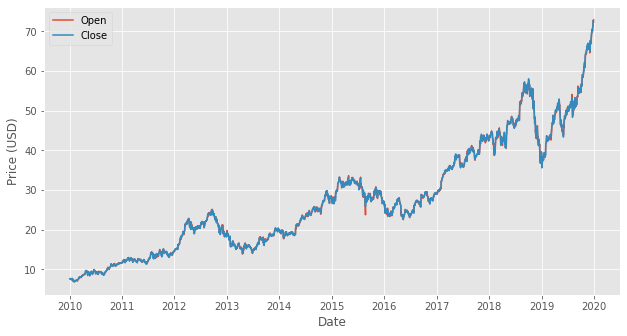

In [ ]:
fig = plt.figure(figsize=(10,5))
ax = fig.add_axes([0.1, 0.1, 0.8, 0.8], xlabel='Date', ylabel='Price (USD)')
ax.plot(df['Open'], label='Open')
ax.plot(df['Close'], label='Close')
#plt.grid()
plt.legend()
plt.show()

### moving average
Moving average may act as 'resistance' or 'support', representing the downward and upward trend of the stock, we can predict future trend of stock by refering to the line, and it is unlikely to deviate from the resistance point.

In [ ]:
# moving average to identify the trend
ac = df['Adj Close']
# 100 day moving average
mavg = ac.rolling(window=100).mean()

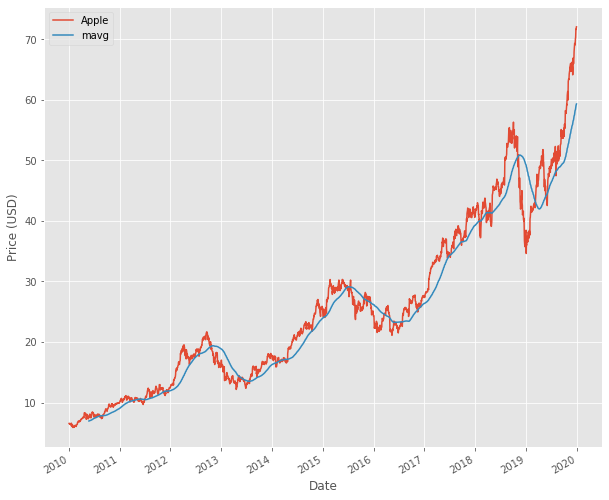

In [ ]:
# plotting
plt.rc('figure', figsize=(10, 9))

ac.plot(label='Apple')
mavg.plot(label='mavg')
plt.ylabel('Price (USD)')
plt.legend()
#plt.grid()
plt.show()

### Risk evaluation

In [ ]:
df['returns'] = df['Adj Close'].pct_change()
returns = df['returns'].dropna()

In [ ]:
# standard deviation
sigma = np.std(returns)
print("standard deviation: ", sigma)

# variance
variance = sigma**2
print("variance: ", variance)

standard deviation:  0.01621946702193634
variance:  0.00026307111047568045


A higher standard deviation means a higher risk, because the data distribution is further away from the mean, the return is more unstable. In this case, standard deviation is 0.016, it means that for the period from 2010 to 2019, the risk of investing in Apple stock is not high.

# 2. Pre-processing
## Types of processing 
When dealing with timeseries forecasting there are two major ways to preprocess the data depending on the type of model you wish to build.

### Many-to-many pre-processing
This technique uses many data-points to predict many datapoints, such as taking 5 past time steps and predicting the next 2. There are many used and many predicted.

### Many-to-one
This technique uses many data-points to predict one datapoints, such as taking 5 past time steps and predicting the next 1. Use of multiple timesteps to predict a single output.

### Required 3-D inputs 
- Tensor: A vector entering the model
- Timestep: A observation from the tensor
- Feature: A observation at a timestep

1-D array should be converted to a 3-D array as follows:

[\# samples, \# timesteps, \# features]

good article on this:
https://medium.com/swlh/a-technical-guide-on-rnn-lstm-gru-for-stock-price-prediction-bce2f7f30346

In [ ]:
# from combination of files and different variable names
stock = df.copy()
# Produce 4 tensors of 5 timestep using 2 features - adj close and volume
test_data = stock[['Adj Close', 'Volume']].iloc[:20].values
test_data.reshape((4, 5, 2))

array([[[6.57242203e+00, 4.93729600e+08],
        [6.58378410e+00, 6.01904800e+08],
        [6.47906065e+00, 5.52160000e+08],
        [6.46708202e+00, 4.77131200e+08],
        [6.51007795e+00, 4.47610800e+08]],

       [[6.45265007e+00, 4.62229600e+08],
        [6.37925148e+00, 5.94459600e+08],
        [6.46923208e+00, 6.05892000e+08],
        [6.43176556e+00, 4.32894000e+08],
        [6.32427883e+00, 5.94067600e+08]],

       [[6.60405397e+00, 7.30007600e+08],
        [6.50240183e+00, 6.12152800e+08],
        [6.38999939e+00, 6.08154400e+08],
        [6.07306385e+00, 8.81767600e+08],
        [6.23644543e+00, 1.06569960e+09]],

       [[6.32458735e+00, 1.86711000e+09],
        [6.38416529e+00, 1.72256840e+09],
        [6.12035894e+00, 1.17350240e+09],
        [5.89831877e+00, 1.24595240e+09],
        [5.98031712e+00, 7.49876400e+08]]])

### Data pre-processing function

In [ ]:
def data_preprocess(df, time_steps, for_periods, test_year, cols):
    '''
    input: 
      data: dataframe with dates and price data
    output:
      X_train, y_train: data from last timestep of year before test_year
      X_test:  data from first timestep of test_year
    time_steps: # of the input time steps
    for_periods: # of the output time steps
    test_year: year to use for test data
    cols: columns to use as features
    '''
    # create training and test set based on year and columns
    train = df[:str(int(test_year)-1)][cols].values
    test  = df[str(int(test_year)):][cols].values
    train_len = len(train)
    test_len = len(test)
    
    # scale the data
    from sklearn.preprocessing import MinMaxScaler
    scaler = MinMaxScaler(feature_range=(0,1))
    train_scaled = scaler.fit_transform(train)
    test_scaled = scaler.transform(test)

    # create training data of s samples and t time steps
    X_train, y_train, y_train_stacked = [], [], []
    for i in range(time_steps,train_len-1): 
        X_train.append(train_scaled[i-time_steps:i,0])
        y_train.append(train_scaled[i:i+for_periods,0])
    X_train, y_train = np.array(X_train), np.array(y_train)
    

    # Reshaping X_train for efficient modelling
    # Tensor, timestep, features
    X_train = np.reshape(X_train, (X_train.shape[0],X_train.shape[1],len(cols)))

    # Preparing to create X_test
    inputs = np.concatenate((train_scaled, test_scaled),axis=0)
    inputs = inputs[len(inputs)-len(test) - time_steps:]
    inputs = inputs.reshape(-1,1)

    X_test = []
    for i in range(time_steps,test_len+time_steps-for_periods):
        X_test.append(inputs[i-time_steps:i,0])
        
    X_test = np.array(X_test)
    X_test = np.reshape(X_test, (X_test.shape[0],X_test.shape[1],1))

    return X_train, y_train , X_test, scaler

test_year = 2019
X_train, y_train, X_test, scaler = data_preprocess(stock,60,1,test_year, ['Adj Close'])
print('X training data shape:', X_train.shape)
print('y training data shape:', y_train.shape)
print('X testing data shape:', X_test.shape)

X training data shape: (2203, 60, 1)
y training data shape: (2203, 1)
X testing data shape: (250, 60, 1)


# 3. Modelling

Building a naive estimator. By that I mean your model’s prediction is largely based on the previous point. This seems to be the most common problem in stock prediction. Building a model that mitigates this and remains accurate is essentially the key, and thus, the difficult part.[1]

[1] - https://towardsdatascience.com/stock-prediction-using-recurrent-neural-networks-c03637437578  (Wyatt Smith, J. PhD)

In the article he uses extra datasources for predictions particularly looking at news sentiment and achieves a 65% accuracy on predictions for stock movement direction. 51% is enough to make money. Also all code is psudeo because it actually works and this is finance.

## Plotting

In [ ]:
def actual_pred_plot(preds, df, test_year, start=0, end=99999, target='Adj Close'):
    '''
    Plot the actual vs. prediction
    added varible year and varible target
    df: original dataframe
    test_year: must be the same as test year used to split data
    target: varible for value to predict
    '''
    import matplotlib.pyplot as plt
    #style.use('classic')
    # Create dataframe for test and predictions
    cols=[target, 'prediction']
    actual_pred = pd.DataFrame(columns = cols)
    actual_pred[target] = df.loc[str(int(test_year)):,target][0:len(preds)]
    actual_pred['prediction'] = preds[:,0]
    actual_pred = actual_pred.iloc[start:end]
    # Calculate the mse
    from keras.metrics import MeanSquaredError
    m = MeanSquaredError()
    m.update_state(np.array(actual_pred[target]),np.array(actual_pred['prediction']))
    # Outputs
    print('The mse error is', round(m.result().numpy(), 2))
    actual_pred.plot(grid=True, ylabel='Price (USD)')

## RNN
- Return Sequences: Must be true for all layers apart from last to maintain the models 3D shape.
- Normilisation: Batch Normalisation has been tested and found to reduce model performance significantly. 

- Optimisers: Tested Adam, SGD and rmsprop. Adam performed adaquently, SGD horribly and rmsprop significantly the best.

- Loss: MSE used as it is a regression.

- Batch_size: Altering batch size reduces model performance, according to offical tensorflow documentation "Do not specify the batch_size if your data is in the form of a dataset, generators, or keras.utils.Sequence instances (since they generate batches)." [1] Data is in form Sequence.

- Hidden Layers: Increased performance from only two hidden layers.

- Nodes: 64 found to be best, 128 overfits and performs poorly on validation and 32 underfits.

- Activation layer: Dense performs marginally better and allows for different activation functions.


[1] - https://www.tensorflow.org/api_docs/python/tf/keras/Model

In [ ]:
# Set sedd for reproducability 
tf.random.set_seed(42) # 42 because it's the answer to life the universe and everything
# model
rnn_model = keras.models.Sequential([
    keras.layers.SimpleRNN(64, return_sequences=True),
    keras.layers.SimpleRNN(64),
    keras.layers.Dense(1)
])
# callbacks
early_stopping = keras.callbacks.EarlyStopping(monitor='val_loss', patience=25, restore_best_weights=True)
# training
rnn_model.compile(loss="mse", optimizer="rmsprop")
history = rnn_model.fit(X_train, y_train, epochs=100, validation_split=0.2, callbacks=[early_stopping]) #rember to ut epochs back to 100

Run time approx 2-3 mins using GPU acceleration on colab.

The mse error is 1.78


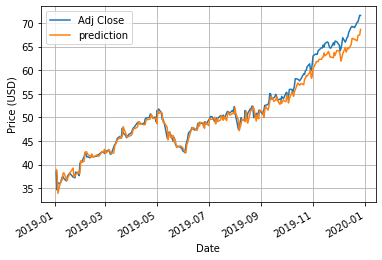

In [ ]:
rnn_preds = rnn_model.predict(X_test)
actual_pred_plot(scaler.inverse_transform(rnn_preds), stock, test_year) 

Strong start and weak finish. This is due to the transfomations the data goes through and the information loss at each step, this can be solved through the use of a LSTM cell that introduces increased memory.

The mse error is 4.28


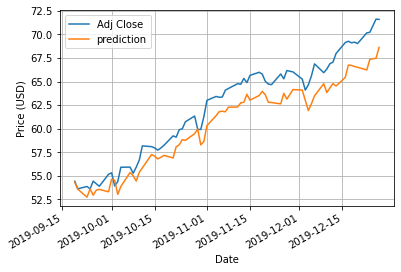

In [ ]:
actual_pred_plot(scaler.inverse_transform(rnn_preds), stock, test_year, start=180,end=300) 

In [ ]:
#rnn_model.save('RNN_31.1_mse')

## LSTM
Long short term memory cells, a type of recurrent nueral network, first proposed in [1].

As the LSTM is a form of RNN many of the previous discoveries have been reapplied to this model arcitecture.

[1] - https://direct.mit.edu/neco/article/9/8/1735/6109/Long-Short-Term-Memory

In [ ]:
#model
lstm_model = keras.models.Sequential([
    keras.layers.LSTM(64, return_sequences=True),
    keras.layers.LSTM(64),
    keras.layers.Dense(1)
])

# early stopping callback
early_stopping = keras.callbacks.EarlyStopping(monitor='val_loss', patience=25, restore_best_weights=True)

# train the model
lstm_model.compile(loss="mse", optimizer="rmsprop")
history = lstm_model.fit(X_train, y_train, epochs=100, validation_split=0.2, callbacks=[early_stopping])

Approx runtime - 5 mins, colab GPU.

The mse error is 1.59


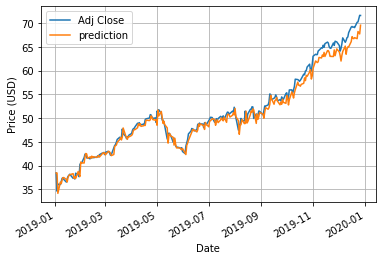

In [ ]:
lstm_preds = lstm_model.predict(X_test)
actual_pred_plot(scaler.inverse_transform(lstm_preds), stock, test_year) 

Now thats a significantly better finish.

The mse error is 3.55


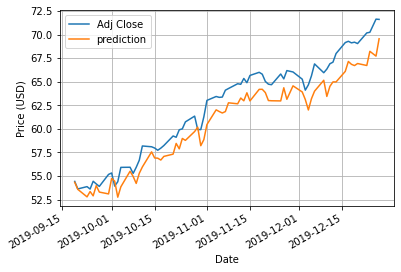

In [ ]:
actual_pred_plot(scaler.inverse_transform(lstm_preds), stock, test_year, start=180) 

In [ ]:
#lstm_model.save('LSTM_13.3_mse')

## GRU
To add.

In [ ]:
#model
GRU_model = keras.models.Sequential([
    keras.layers.GRU(64, return_sequences=True),
    keras.layers.GRU(64),
    keras.layers.Dense(1)
])

# early stopping callback
early_stopping = keras.callbacks.EarlyStopping(monitor='val_loss', patience=25, restore_best_weights=True)

# train the model
GRU_model.compile(loss="mse", optimizer="rmsprop")
history = GRU_model.fit(X_train, y_train, epochs=100, validation_split=0.2, callbacks=[early_stopping])

Approx runtime is long.

The mse error is 0.67


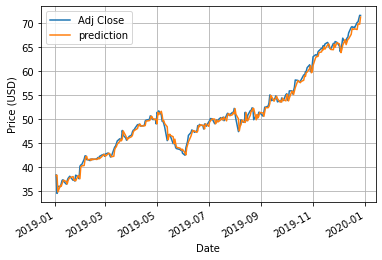

In [ ]:
GRU_preds = GRU_model.predict(X_test)
actual_pred_plot(scaler.inverse_transform(GRU_preds), stock, test_year) 

The mse error is 0.68


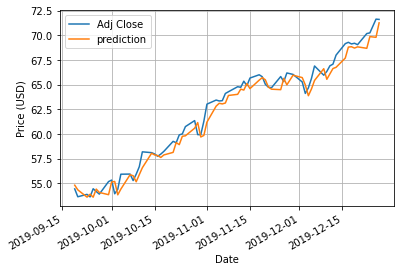

In [ ]:
actual_pred_plot(scaler.inverse_transform(GRU_preds), stock, test_year, start=180) 

The mse error is 0.66


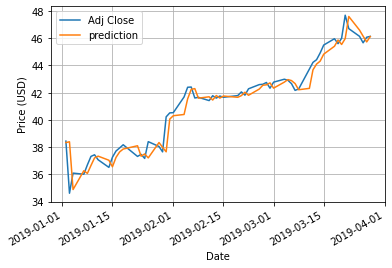

In [ ]:
actual_pred_plot(scaler.inverse_transform(GRU_preds), stock, test_year, start=0,end=60) 

## Conv1D + GRU

In [ ]:
Conv1D_model = keras.models.Sequential([
    keras.layers.Conv1D(filters=10, kernel_size=4, strides=1, padding="valid",
                        input_shape=[None, 1]),
    keras.layers.GRU(64),
    keras.layers.Dense(1)
])

# early stopping callback
early_stopping = keras.callbacks.EarlyStopping(monitor='val_loss', patience=25, restore_best_weights=True)

# train the model
Conv1D_model.compile(loss="mse", optimizer="rmsprop")
history = Conv1D_model.fit(X_train, y_train, epochs=100, validation_split=0.2, callbacks=[early_stopping])

The mse error is 0.71


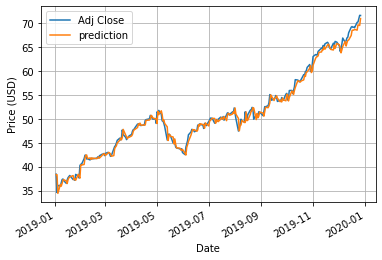

In [ ]:
Conv1D_preds = Conv1D_model.predict(X_test)
actual_pred_plot(scaler.inverse_transform(Conv1D_preds), stock, test_year) 

The mse error is 0.79


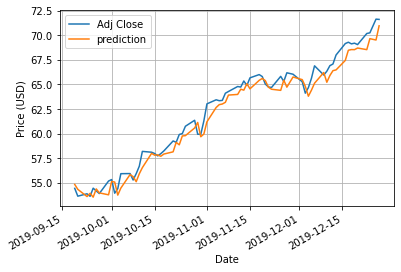

In [ ]:
actual_pred_plot(scaler.inverse_transform(Conv1D_preds), stock, test_year, start=180) 